# Flood Impact Assessment using Sentinel 1 data

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc), [esa_worldcover](https://explorer.digitalearth.africa/products/esa_worldcover), [dem_srtm](https://explorer.digitalearth.africa/products/dem_srtm),

## Background

Floods are the most important hazard in Africa in terms of frequency and magnitude, more than drought and war. Many countries are susceptible to many natural hazards. Disasters kill more people in Africa than elsewhere in the world (WHO/EHA, 1999).

Flooding causes major disruptions in cities and areas whith agricultural activities. This leads to significant impacts on economy, people and on the environment. Earth Observation systems are useful in monitoring water extent particularly in areas where rivers are not equiped with gauge.When it comes to flood management, Synthetic Aperture Radar (SAR) is the most preferable microwave radar due to its ability to differentiate between water and other objects. 


Urban areas account for a small proportion of global land cover, but support daily human life and exert a great influence on environmental and ecological changes ([Xia et al. 2019](https://doi.org/10.3390/rs11121470)). 
This means that constant monitoring of the built environment is crucial for sustainable development. 
There are different techniques used to classify urban areas using both optical and radar data, one of the simplest is k-means clustering (unsupervised machine learning). 

While urban areas can be mapped using optical data, the image quality is strongly affected by weather conditions such as cloud cover. 
This limits the temporal avaliability of clear images in tropical areas that experience very cloudy weather and heavy rains. 
The image quality of radar data is independent of daylight and weather conditions, which makes it more suitable for urban area mapping. 
For more information, see the [Sentinel-1](../Datasets/Sentinel_1.ipynb) notebook.

## Description

This notebook uses k-means clustering to classify land as 'urban' then compares those results with the ESA WorldCover global land cover product for the year 2020.

The choice of the number of clusters to use for the k-means clustering and the pixel value that represents the urban land cover class can be informed by comparing the prediction images with the "ground truth" dataset.

This notebook contains the following steps:

1. Select a location and time range  for the analysis.
2. Load Sentinel-1 backscatter data for the area of interest. 
3. Convert the digital numbers to dB values for analysis.
4. Generate a median VH and VV polarization composite image from the Sentinel 1 data.
5. Perform k-means clustering on the median composite image. 
6. Show the k-means clustering urbanization prediction image.
7. Load and show the "ground truth" ESA Worldcover data for the year 2020.
8. Compare the urbanization prediction with the "ground truth" data visually and statistically.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import the Python packages that are used for the analysis.

In [95]:
# Load the necessary Python packages.
%matplotlib inline

import warnings

import datacube
import matplotlib.colors as mcolours
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

warnings.filterwarnings("ignore")

from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, plot_lulc
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from deafrica_tools.plotting import rgb

## Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [96]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:44537' processes=1 threads=2, memory=13.11 GB>

### Connect to the datacube

Connect to the datacube so we can access the Digital Earth Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [97]:
dc = datacube.Datacube(app="Urban_area_mapping")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis.
The parameters are:
* `central_lat`: The central latitude of the area of interest to analyse.
* `central_lon`: The central longitude of the area of interest to analyse.
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The time range for your analysis, e.g.`('2020')` if you wanted data from all of the year 2020.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers part of Lokoja, a city in Nigeria. It lies at the confluence of the Niger and Benue rivers and is the capital of Kogi State. 

In [118]:
# Define the area of interest.
central_lat =  6.590
central_lon =  3.640676
lat_buffer = 0.15
lon_buffer = 0.40

# Combine lat, lon with their respective buffers to get area of interest.
lat_range = (central_lat - lat_buffer, central_lat + lat_buffer)
lon_range = (central_lon - lon_buffer, central_lon + lon_buffer)

# Time frame for the analysis.
time_range = ("2021-07", "2021-09")

### View the selected location

The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [119]:
# View the study area
display_map(x=lon_range, y=lat_range)

## Load and view the Sentinel-1 data

### Create a datacube query object
We will create a dictionary that will contain the parameters that will be used to load the Sentinel 1 data from the Digital Earth Africa datacube.

In [120]:
query = {
    "y": lat_range,
    "x": lon_range,
    "time": time_range,
    "output_crs": "EPSG:32632",
    "resolution": (-20, 20),
    "dask_chunks": dict(x=1000, y=1000),
}

### Load the Sentinel 1 data
The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest.
This uses the pre-defined [load_ard](../Frequently_used_code/Using_load_ard.ipynb) utility function. 
The `load_ard` function is used here to load an analysis ready dataset free of shadow, and missing data.

In [121]:
ds_origin = load_ard(
    dc=dc, products=["s1_rtc"], 
    measurements=["vv", "vh"], 
    group_by="solar_day",
    sat_orbit_state= 'ascending',
    **query
)

ds_origin

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 7 time steps as a dask array


<xarray.Dataset>
Dimensions:      (time: 7, y: 1714, x: 4460)
Coordinates:
  * time         (time) datetime64[ns] 2021-07-12T18:02:12.245465 ... 2021-09...
  * y            (y) float64 7.488e+05 7.488e+05 ... 7.145e+05 7.145e+05
  * x            (x) float64 -1.379e+05 -1.379e+05 ... -4.875e+04 -4.873e+04
    spatial_ref  int32 32632
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:32632
    grid_mapping:  spatial_ref

In [122]:
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.filters import threshold_minimum


def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output

valid = xr.ufuncs.isfinite(ds_origin)
ds_origin = ds_origin.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
ds_origin["filtered_vv"] = ds_origin.vv.groupby("time").apply(lee_filter, size=5)
ds_origin["filtered_vh"] = ds_origin.vh.groupby("time").apply(lee_filter, size=5)

# Null pixels should remain null
ds_origin['filtered_vv'] = ds_origin.filtered_vv.where(valid.vv)
ds_origin['filtered_vh'] = ds_origin.filtered_vh.where(valid.vh)

## Convert the Digital Number (DN) values to Decibel values (dB)

The Sentinel-1 backscatter data is provided as digital number (DN), which can be converted to backscatter in decibel unit (dB) using the function:

\begin{equation}
10 * \log_{10}\left(\text{DN} \right)
\end{equation}


It is often useful to convert the backscatter to decible (dB) for analysis because the backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.

In [123]:
# Convert DN to db values.
ds_origin["vv"] = 10 * xr.ufuncs.log10(ds_origin.filtered_vv)
ds_origin["vh"] = 10 * xr.ufuncs.log10(ds_origin.filtered_vh)

### View the Sentinel 1 data

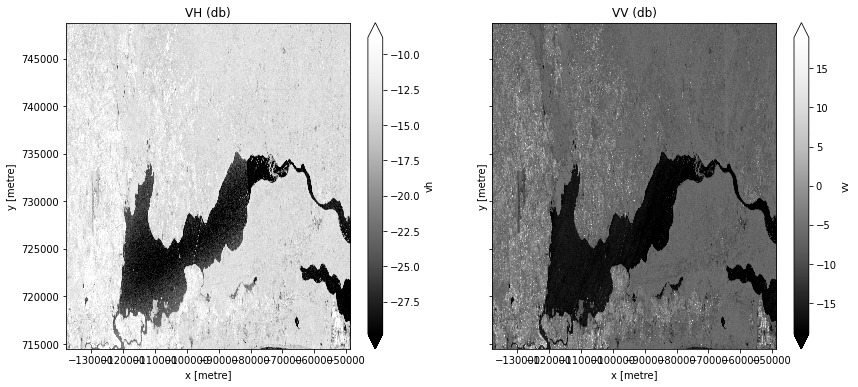

In [124]:
# Plot the first VH and VV observation for the year 2020.
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
ds_origin.vh.isel(time=0).plot.imshow(cmap="Greys_r", robust=True, ax=ax[0])
ds_origin.vv.isel(time=0).plot.imshow(cmap="Greys_r", robust=True, ax=ax[1])
ax[0].set_title("VH (db)")
ax[1].set_title("VV (db)");

In [125]:
ds_origin.time

<xarray.DataArray 'time' (time: 7)>
array(['2021-07-12T18:02:12.245465000', '2021-07-24T18:02:12.960852000',
       '2021-08-05T18:02:13.697758000', '2021-08-17T18:02:14.227978000',
       '2021-08-29T18:02:14.808179000', '2021-09-10T18:02:15.417513000',
       '2021-09-22T18:02:15.788039000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2021-07-12T18:02:12.245465 ... 2021-09...
    spatial_ref  int32 32632
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [126]:
ds_selected = ds_origin.isel(time=[0, 6])
ds_selected = ds_selected.compute()

In [127]:
ds_selected.vv.plot(cmap="Greys_r", col='time', size=6)

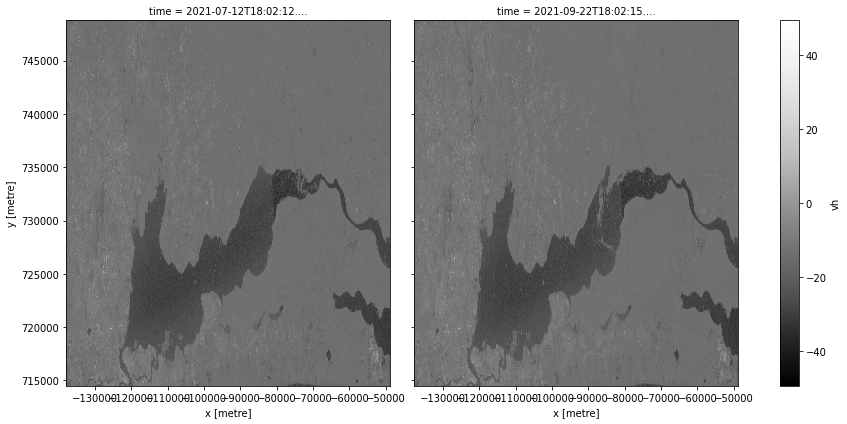

In [128]:
ds_selected.vh.plot(cmap="Greys_r", col='time', size=6)

In [133]:
ds_selected['vh/vv'] = ds_selected.vh/ds_selected.vv

In [134]:
# plotting an RGB image for selected timesteps
rgb(ds_selected[['vv','vh','vh/vv']], bands=['vv',
    'vh', 'vh/vv'], index=[0, 1], size=6);

### Selection of SAR polarization
SAR polarization is a key factor in flood detection. HH-polarized images are more adequate for flood detection than VV- or crosspolarized images (Baghdadi, et al., 2001; Henry, et al., 2006). HH-polarization gives the highest distinction in backscatter values between dry and wet forested areas (Henry et al., 2006; Jüssi, 2015). For this pratical exercice the available image during the flood had an Intensity VV and VH polarization. The VV polarization was preferred because the medium incident angle of the data makes this image suitable for flood monitoring.

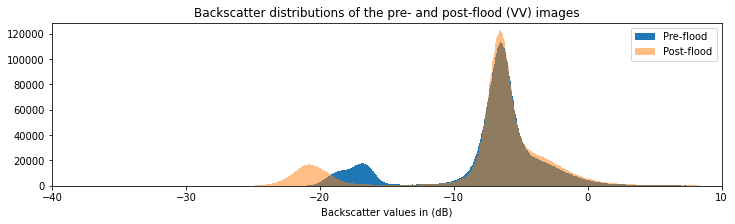

In [135]:
fig = plt.figure(figsize=(12, 3))
ds_selected.isel(time=0).vv.plot.hist(bins=1000, label="Pre-flood")
ds_selected.isel(time=1).vv.plot.hist(bins=1000, label="Post-flood", alpha=0.5)
plt.xlim(-40, 10)
plt.legend()
plt.xlabel("Backscatter values in (dB)")
plt.title("Backscatter distributions of the pre- and post-flood (VV) images");

### Threshold determination
To separate water from non-water a threshold can be selected. The histogram above shows peaks of different magnitude. Low values of the backscatter will correspond to the water, and high values will correspond to the non-water class. We need to select the value that will separate water from non-water. This value corresponds in our case to the threshold.

In [136]:
from skimage.filters import threshold_minimum

threshold_vv = threshold_minimum(ds_selected.vv.values)

print(threshold_vv)

-13.035705


### Water / non Water Seperation 

In [137]:
ds_selected_water = ds_selected.vv < threshold_vv

In [138]:
ds_july = ds_selected_water.where(ds_selected_water==True, 0).isel(time=0)
ds_september = ds_selected_water.where(ds_selected_water==True, 0).isel(time=1)

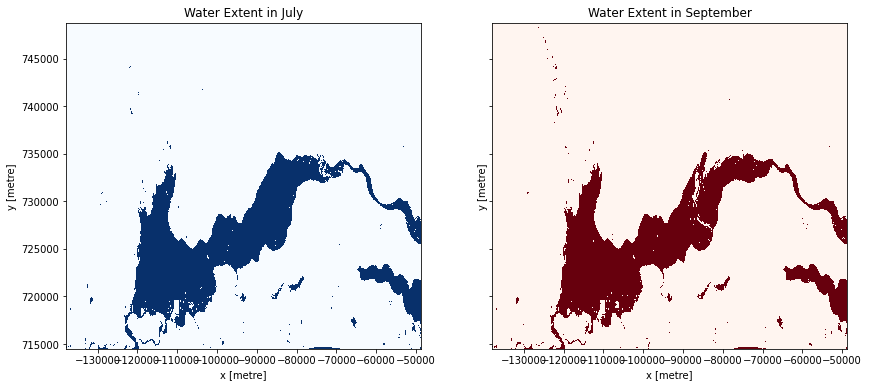

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
ds_july.plot(cmap='Blues',  robust=True, ax=ax[0], add_colorbar=False)
ds_september.plot(cmap='Reds',  robust=True, ax=ax[1], add_colorbar=False)
ax[0].set_title("Water Extent in July")
ax[1].set_title("Water Extent in September");

### Water Change Detection

In [140]:
change =   ds_september - ds_july

In [141]:
water_appeared = change.where(change == 1)
permanent_water = change.where((change == 0) & (ds_july > 0))
water_disappeared = change.where(change == -1)

Text(0.5, 1.0, 'Change in Water Extent')

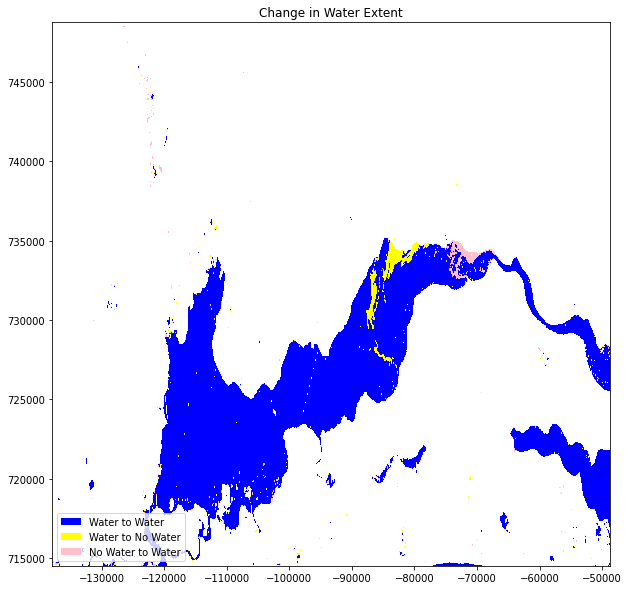

In [142]:
water_appeared_color = "Pink"
water_disappeared_color = "Yellow"
stable_color = "Blue"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))


permanent_water.plot.imshow(
    cmap=ListedColormap([stable_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)

water_appeared.plot.imshow(
    cmap=ListedColormap([water_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)

water_disappeared.plot.imshow(
    cmap=ListedColormap([water_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)

plt.legend(
    [
        Patch(facecolor=stable_color),
        Patch(facecolor=water_disappeared_color),
        Patch(facecolor=water_appeared_color),
    ],
    [
        f"Water to Water",
        f"Water to No Water",
        f"No Water to Water",
    ],
    loc="lower left",
)

#plt.title("Change in water extent: " + baseline_time + " to " + analysis_time);
plt.title("Change in Water Extent")

# Land Cover Land Use Classification

### Classification using K-means Clustering

K-means is an unsupervised classification algorithm, also called clusterization, that groups objects into k groups based on their characteristics. The grouping is done minimizing the sum of the distances between each object and the group or cluster centroid.


In the next cell we will create a set of functions which will together be used to perform k-means clustering on our median value composite image. 
This functions are adapted from the ones used [here](https://ml-gis-service.com/index.php/2020/10/14/data-science-unsupervised-classification-of-satellite-images-with-k-means-algorithm/).

In [149]:
# Defining functions to use for the k-means clustering.
def show_clustered(predicted_ds):
    """
    Takes the predicted xarray DataArray and plots it.

    Last modified: November 2021
    Parameters
    ----------
    predicted_ds : xarray DataArrray
    The xarray DataArray which is the result of the k-means clustering.

    Returns
    -------
    An plot of the predicted_ds.
    """

    # Display predicted_ds Dataset with upto 6 unique classes.
    image = predicted_ds

    # Color list with 6 colors from the virdis color map.
    no_classes = len(np.unique(image))
    colour_list = ["#fde725", "#440154", "#22a884", "#414487", "#2a788e", "#7ad151"]
    colours = colour_list[:no_classes]
    cmap = mcolours.ListedColormap(colours)
    bounds = range(0, no_classes + 1)
    norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)
    cblabels = [str(i) for i in bounds]
    im = image.plot.imshow(cmap=cmap, norm=norm, add_colorbar=True, figsize=(6, 6))
    cb = im.colorbar
    cb.set_ticks(np.arange(0, no_classes + 1, 1) + 0.5)
    cb.set_ticklabels(cblabels)
    plt.axis("off")
    title = f"K-means Clustering Predicted Image using {no_classes} clusters"
    plt.title(title)
    plt.show()


def kmeans_clustering(input_xr, cluster_range):
    """
    Perform sklearn Kmeans clustering on the input Dataset
    or Data Array.

    Last modified: November 2021

    Parameters
    ----------
    input_xr : xarray.DataArray or xarray.Dataset
        Must have dimensions 'x' and 'y', may have dimension 'time'.

    cluster_range : list
        A list of the number of clusters to use to perform the k-means clustering
        on the input_xr Dataset.

    Returns
    ----------
    results : dictionary
        A dictionary with the number of clusters as keys and the predicted xarray.DataArrays
        as the values. Each predicted xarray.DataArray has the same dimensions 'x', 'y' and
        'time' as the input_xr.

    """

    # Use the sklearn_flatten function to convert the Dataset or DataArray into a 2 dimensional numpy array.
    model_input = sklearn_flatten(input_xr)

    # Standardize the data.
    scaler = StandardScaler()
    model_input = scaler.fit_transform(model_input)

    # Dictionary to save results
    results = {}

    # Perform Kmeans clustering on the input dataset for each number of clusters
    # in the cluster_range list.
    for no_of_clusters in cluster_range:
        # Set up the kmeans classification by specifying the number of clusters
        # with initialization as k-means++.
        km = KMeans(n_clusters=no_of_clusters, init="k-means++", random_state=1)

        # Begin iteratively computing the position of the clusters.
        km.fit(model_input)

        # Use the sklearn kmeans .predict method to assign all the pixels of the
        # model input to a unique cluster.
        flat_predictions = km.predict(model_input)

        # Use the sklearn_unflatten function to convert the flat predictions into a
        # xarray DataArray.
        predicted = sklearn_unflatten(flat_predictions, input_xr)
        predicted = predicted.transpose("y", "x")

        # Append the results to a dictionary using the number of clusters as the
        # column as an key.
        results.update({str(no_of_clusters): predicted})

    return results

In the next cell, we will use a range of clusters to perform  k-means classification on our median composite dataset.

Below, **enter the selected polarization to include in the classification**

In [150]:
bands = ["vv"]

Now we will run the k-means classification, and then plot the results

In [151]:
july_urban = ds_selected.isel(time=0)
september_urban = ds_selected.isel(time=0)

In [152]:
july_urban = july_urban.where(july_urban.apply(np.isfinite)).fillna(0.0)
september_urban = september_urban.where(september_urban.apply(np.isfinite)).fillna(0.0)

In [153]:
cluster_range = [2, 3, 4]
results_july = kmeans_clustering(july_urban[bands], cluster_range)
results_september = kmeans_clustering(september_urban[bands], cluster_range)

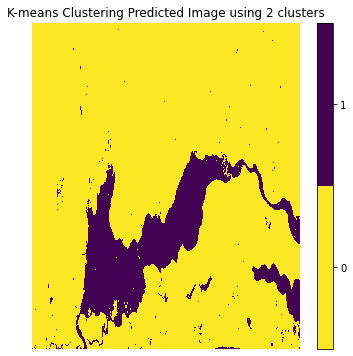

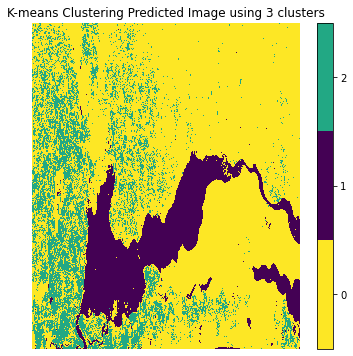

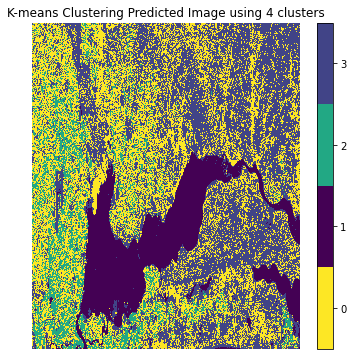

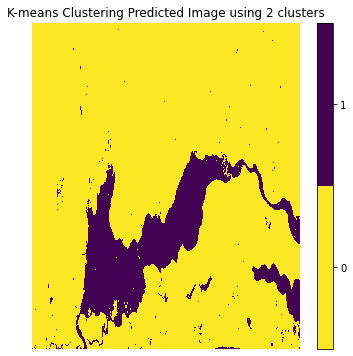

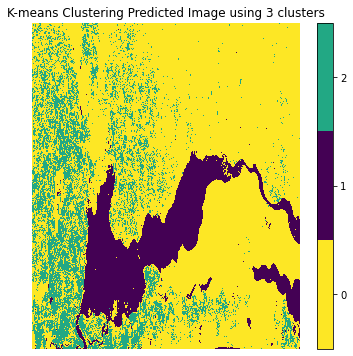

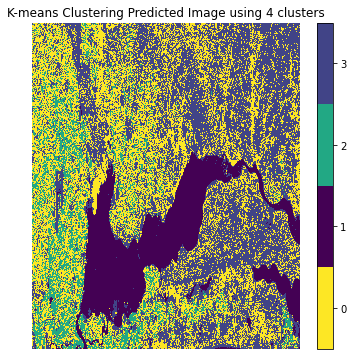

In [154]:
# Plot each of the predicted images.
for predicted_ds in results_july.values():
    show_clustered(predicted_ds)
    
for predicted_ds in results_september.values():
    show_clustered(predicted_ds)

## Decide which model and class to assign as 'urban'

#### From the plotted predicted images above the best number of clusters to use is `3` clusters. 
In this image, the most likely pixel value to represent the urban/buit up land cover class is the pixel value `2`. 

> Note: this may change depending on the area of interest and number of clusters used. In this example, the initial state has been arbitrarily defined using the `random_state` argument in the `kmeans_clustering` function.

Set the `key` and the `pixel_value` representing the model and value, respectively, that you want to assign as urban areas

In [155]:
# Mask the dataset to retain the pixels which are most likely to be urban/built up.
key = "3"
pixel_value = 2

clustering_predicted_ds_july = results_july[key] == pixel_value
clustering_predicted_ds_september = results_september[key] == pixel_value

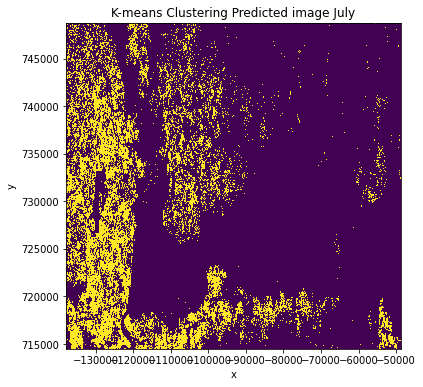

In [156]:
clustering_predicted_ds_july.plot.imshow(figsize=(6, 6), add_colorbar=False)
plt.title("K-means Clustering Predicted image July");

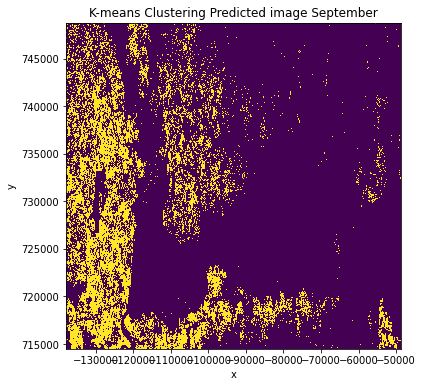

In [157]:
clustering_predicted_ds_september.plot.imshow(figsize=(6, 6), add_colorbar=False)
plt.title("K-means Clustering Predicted image September");

## Validation of the k-means clustering classification
We will compare the performance of the urban area k-means clustering classification result against a built area (urban area) map for the study area derived from the ESA World Cover, global 10 m land use/land cover data from 2020. 

### Obtain the validation dataset

In [158]:
# Load the ESA land use land cover product over the same region as the Sentinel 1 dataset.
ds_esa = dc.load(product="esa_worldcover", like=ds_selected.geobox).squeeze()
#cci_landcover
ds_esa

<xarray.Dataset>
Dimensions:         (y: 1714, x: 4460)
Coordinates:
    time            datetime64[ns] 2020-07-01T12:00:00
  * y               (y) float64 7.488e+05 7.488e+05 ... 7.145e+05 7.145e+05
  * x               (x) float64 -1.379e+05 -1.379e+05 ... -4.875e+04 -4.873e+04
    spatial_ref     int32 32632
Data variables:
    classification  (y, x) uint8 50 50 50 50 50 50 50 ... 60 60 60 30 30 30 60
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

### Plot the ESA land use land cover product.

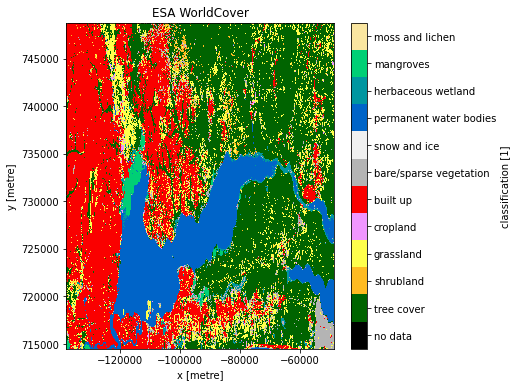

In [159]:
# Plot the ESA land use land cover product.
fig, ax = plt.subplots(figsize=(6, 6), sharey=True)
plot_lulc(ds_esa["classification"], product="ESA", legend=True, ax=ax)
plt.title("ESA WorldCover");

### Plot the ESA urban areas alongside the k-means estimate from S1

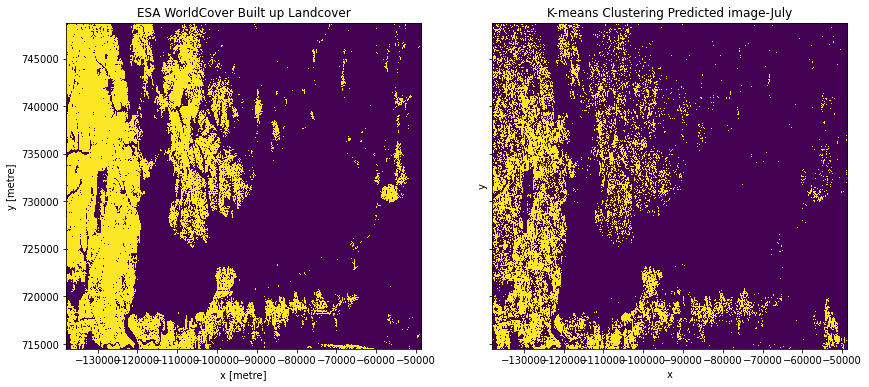

In [160]:
# Plot the built up land cover from the ESA worldcover dataset.
esa_urban_class = 50

built_up = ds_esa["classification"] == esa_urban_class
crop_land = ds_esa["classification"] == 40

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
built_up.plot.imshow(ax=ax[0], add_colorbar=False)
clustering_predicted_ds_july.plot.imshow(ax=ax[1], add_colorbar=False)
ax[1].set_title("K-means Clustering Predicted image-July")
ax[0].set_title("ESA WorldCover Built up Landcover");

### Accuracy assessment metrics
We will use functions from the `sklearn.metrics` module to evaluate the k-means clustering classification. 
Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. 

$$
\begin{aligned}
\text{Overall Accuracy (OA)} = \frac{\text{True Positive} + \text{True Negative}}{\text{Total Pixels}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Producer's Accuracy (PA) or Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}
\end{aligned}
$$

$$
\begin{aligned}
\text{User's accuracy (UA) or  Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
\end{aligned}
$$

$$
\begin{aligned}
\text{F1 Score} = 2*\frac{\text{Recall}*\text{Precision}}{\text{Recall} + \text{Precision}}
\end{aligned}
$$


In [161]:
# Metrics for the Kmeans Clustering.
y_true = sklearn_flatten(built_up)
y_pred_kmeans = sklearn_flatten(clustering_predicted_ds_july)

# Producer's Accuracies.
precision_kmeans = precision_score(y_true, y_pred_kmeans, labels=[0, 1], average=None)
urban_precision_kmeans = precision_kmeans[1] * 100

# User's Accuracies.
recall_kmeans = recall_score(y_true, y_pred_kmeans, labels=[0, 1], average=None)
urban_recall_kmeans = recall_kmeans[1] * 100

# Overall Accuracy.
accuracy_kmeans = accuracy_score(y_true, y_pred_kmeans, normalize=True)
overall_accuracy_kmeans = accuracy_kmeans * 100

# F1 score.
f1score_kmeans = f1_score(y_true, y_pred_kmeans)

In [162]:
print(
    "\033[1m" + "\033[91m" + "Urban Area Mapping using k-means clustering Results"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: ", round(overall_accuracy_kmeans, 2))
print("F1 score: \t", round(f1score_kmeans, 2))
print("Producer's Accuracy: ", round(urban_precision_kmeans, 2))
print(
    "User's Accuracy: ",
    round(urban_recall_kmeans, 2),
)

Urban Area Mapping using k-means clustering Results

Overall Accuracy:  83.43
F1 score: 	 0.62
Producer's Accuracy:  85.7
User's Accuracy:  49.09


The `dstack` calls provide the `imshow` calls with RGB array inputs. 
For the plotted image, the first channel (red) is the actual (ground truth, ESA Worldcover) values, and both the second and third channels (green, blue) are the predicted values (green + blue = cyan).

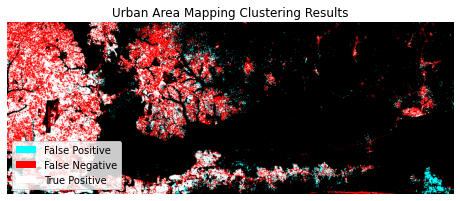

In [163]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(
    np.dstack(
        (
            built_up.data.astype(float),
            clustering_predicted_ds_july.data.astype(float),
            clustering_predicted_ds_july.data.astype(float),
        )
    )
)
plt.legend(
    [Patch(facecolor="cyan"), Patch(facecolor="red"), Patch(facecolor="white")],
    ["False Positive", "False Negative", "True Positive"],
    loc="lower left",
    fontsize=10,
)
plt.axis("off")
plt.title("Urban Area Mapping Clustering Results");

Text(0.5, 1.0, 'ESA WorldCover Built up Landcover')

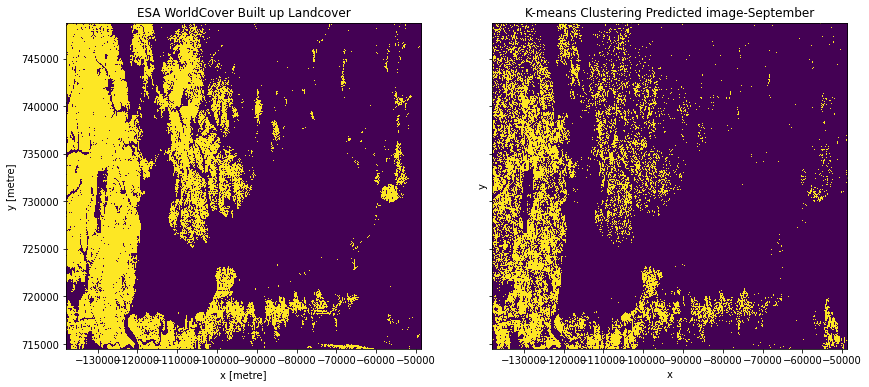

In [164]:
# Plot the built up land cover from the ESA worldcover dataset.
esa_urban_class = 50

built_up = ds_esa["classification"] == esa_urban_class

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
built_up.plot.imshow(ax=ax[0], add_colorbar=False)
clustering_predicted_ds_september.plot.imshow(ax=ax[1], add_colorbar=False)
ax[1].set_title("K-means Clustering Predicted image-September")
ax[0].set_title("ESA WorldCover Built up Landcover")

In [165]:
# Metrics for the Kmeans Clustering.
y_true = sklearn_flatten(built_up)
y_pred_kmeans = sklearn_flatten(clustering_predicted_ds_september)

# Producer's Accuracies.
precision_kmeans = precision_score(y_true, y_pred_kmeans, labels=[0, 1], average=None)
urban_precision_kmeans = precision_kmeans[1] * 100

# User's Accuracies.
recall_kmeans = recall_score(y_true, y_pred_kmeans, labels=[0, 1], average=None)
urban_recall_kmeans = recall_kmeans[1] * 100

# Overall Accuracy.
accuracy_kmeans = accuracy_score(y_true, y_pred_kmeans, normalize=True)
overall_accuracy_kmeans = accuracy_kmeans * 100

# F1 score.
f1score_kmeans = f1_score(y_true, y_pred_kmeans)

In [166]:
print(
    "\033[1m" + "\033[91m" + "Urban Area Mapping using k-means clustering Results September"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: ", round(overall_accuracy_kmeans, 2))
print("F1 score: \t", round(f1score_kmeans, 2))
print("Producer's Accuracy: ", round(urban_precision_kmeans, 2))
print(
    "User's Accuracy: ",
    round(urban_recall_kmeans, 2),
)

Urban Area Mapping using k-means clustering Results September

Overall Accuracy:  83.43
F1 score: 	 0.62
Producer's Accuracy:  85.7
User's Accuracy:  49.09


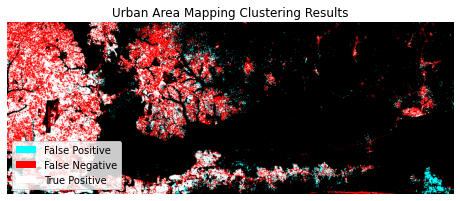

In [167]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(
    np.dstack(
        (
            built_up.data.astype(float),
            clustering_predicted_ds_september.data.astype(float),
            clustering_predicted_ds_september.data.astype(float),
        )
    )
)
plt.legend(
    [Patch(facecolor="cyan"), Patch(facecolor="red"), Patch(facecolor="white")],
    ["False Positive", "False Negative", "True Positive"],
    loc="lower left",
    fontsize=10,
)
plt.axis("off")
plt.title("Urban Area Mapping Clustering Results");

Text(0.5, 1.0, 'September')

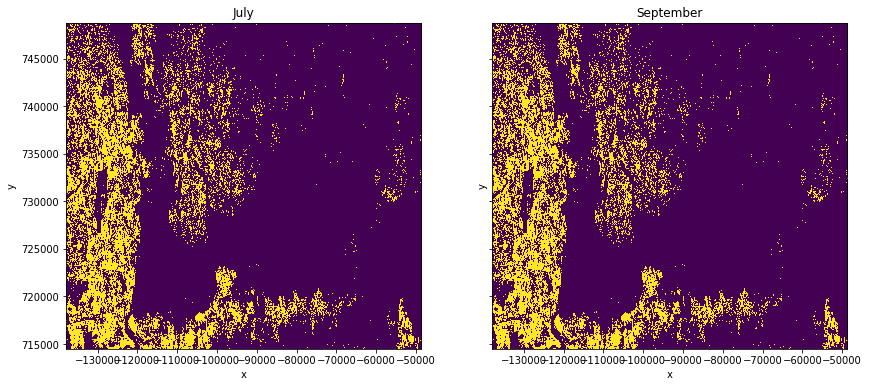

In [168]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
clustering_predicted_ds_july.plot.imshow(ax=ax[0], add_colorbar=False,)
clustering_predicted_ds_september.plot.imshow(ax=ax[1], add_colorbar=False)

ax[0].set_title("July")
ax[1].set_title("September")


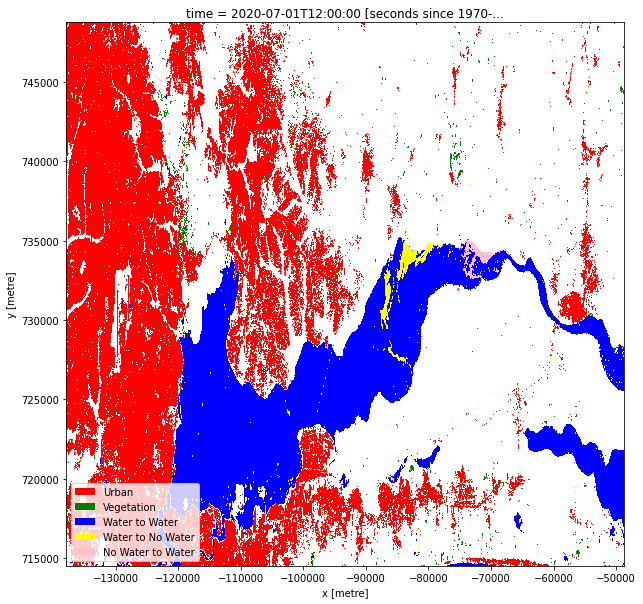

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

built_up.where(built_up == True
                                  ).plot.imshow(cmap=ListedColormap(['Red']),add_colorbar=False, ax=ax)


permanent_water.plot.imshow(
    cmap=ListedColormap([stable_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)

water_appeared.plot.imshow(
    cmap=ListedColormap([water_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
water_disappeared.plot.imshow(
    cmap=ListedColormap([water_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
crop_land.where(crop_land == True
               ).plot.imshow(cmap=ListedColormap(['Green']),
                                       add_colorbar=False,
                                       add_labels=False,
                                       ax=ax)
plt.legend(
    [
        Patch(facecolor='Red'),
        Patch(facecolor='Green'),
        Patch(facecolor=stable_color),
        Patch(facecolor=water_disappeared_color),
        Patch(facecolor=water_appeared_color),
    ],
    [
        f"Urban",
        f"Vegetation",
        f"Water to Water",
        f"Water to No Water",
        f"No Water to Water",
    ],
    loc="lower left",
)


## Flood Risk Assessment using Elevation data

In [170]:
#load the dem 30 m product
ds_elevation = dc.load(product="dem_cop_30",measurements = "elevation", **query).squeeze()
print(ds_elevation)

<xarray.Dataset>
Dimensions:      (y: 1714, x: 4460)
Coordinates:
    time         datetime64[ns] 2000-01-01T12:00:00
  * y            (y) float64 7.488e+05 7.488e+05 ... 7.145e+05 7.145e+05
  * x            (x) float64 -1.379e+05 -1.379e+05 ... -4.875e+04 -4.873e+04
    spatial_ref  int32 32632
Data variables:
    elevation    (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:32632
    grid_mapping:  spatial_ref


In [171]:
ds_elevation.elevation.plot(cmap='ocean',add_colorbar=False, size=7)

In [172]:
ds_high = ds_elevation.assign(high=xr.where(ds_elevation.elevation <= 50, 1, 0))
ds_medium = ds_elevation.assign(high=xr.where(ds_elevation.elevation <= 100, 1, 0))

ds_h =  ds_high.where((ds_high.high == 1)).compute()
ds_m =  ds_medium.where((ds_medium.high == 1) & (ds_high.high == 0)).compute()

In [173]:
#Plot the flood prone built up areas and cropland.
h_affected_urban = built_up.where((built_up == True) & (ds_h.high == 1))
h_affected_vegetation = crop_land.where((crop_land == True) & (ds_h.high == 1))

m_affected_urban = built_up.where((built_up == True) & (ds_m.high == 1))
m_affected_vegetation = crop_land.where((crop_land == True) & (ds_m.high == 1))

unaffected_urban = built_up.where((built_up == True) & (np.isnan(ds_h.high)) & (np.isnan(ds_m.high)))
unaffected_vegetation = crop_land.where((crop_land == True) & (np.isnan(ds_h.high)) & (np.isnan(ds_m.high)))

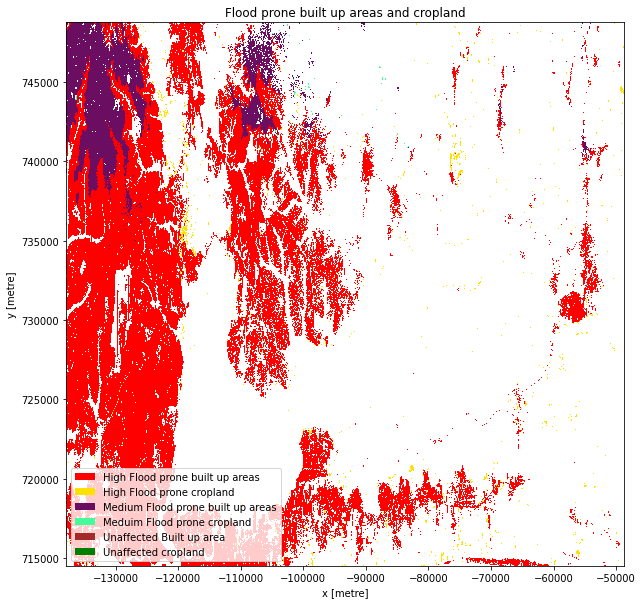

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

h_affected_urban.plot.imshow(cmap=ListedColormap(['#ff0000']), add_colorbar=False, ax=ax)
h_affected_vegetation.plot.imshow(cmap=ListedColormap(['#ffe100']), add_colorbar=False, ax=ax)

m_affected_urban.plot.imshow(cmap=ListedColormap(['#6b0d60']), add_colorbar=False, ax=ax)
m_affected_vegetation.plot.imshow(cmap=ListedColormap(['#44fc9a']), add_colorbar=False, ax=ax)

unaffected_urban.plot.imshow(cmap=ListedColormap(['Brown']), add_colorbar=False, ax=ax)
unaffected_vegetation.plot.imshow(cmap=ListedColormap(['Green']), add_colorbar=False, ax=ax)


plt.legend(
    [
        Patch(facecolor="#ff0000"),
        Patch(facecolor="#ffe100"),
        Patch(facecolor="#6b0d60"),
        Patch(facecolor="#44fc9a"),
        Patch(facecolor="Brown"),
        Patch(facecolor="Green")
    ],
    [
        "High Flood prone built up areas",
        "High Flood prone cropland",
        "Medium Flood prone built up areas",
        "Meduim Flood prone cropland",
        "Unaffected Built up area",
        "Unaffected cropland",
        
    ],
    loc="lower left",
)

plt.title("Flood prone built up areas and cropland");

In [175]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

In [176]:
# Calculate the areas of the flood prone built up areas and cropland.
h_area_affected_urban = np.float((h_affected_urban.sum(dim=['x', 'y']) * area_per_pixel).data)
h_area_affected_cropland = np.float((h_affected_vegetation.sum(dim=['x', 'y']) * area_per_pixel).data)

m_area_affected_urban = np.float((m_affected_urban.sum(dim=['x', 'y']) * area_per_pixel).data)
m_area_affected_cropland = np.float((m_affected_vegetation.sum(dim=['x', 'y']) * area_per_pixel).data)

un_area_affected_urban = np.float((unaffected_urban.sum(dim=['x', 'y']) * area_per_pixel).data)
un_area_affected_cropland = np.float((unaffected_vegetation.sum(dim=['x', 'y']) * area_per_pixel).data)

print(f'Built up area highly prone to flooding: {round(h_area_affected_urban, 3)} kmsq')
print(f'Cropland  area highly prone to flooding: {round(h_area_affected_cropland, 3)} kmsq')
print(f'Built up area meduim prone to flooding: {round(m_area_affected_urban, 3)} kmsq')
print(f'Cropland  area meduim prone to flooding: {round(m_area_affected_cropland, 3)} kmsq')
print(f'Built up area unaffected to flooding: {round(un_area_affected_urban, 3)} kmsq')
print(f'Cropland area unaffected to flooding: {round(un_area_affected_cropland, 3)} kmsq')

Built up area highly prone to flooding: 753.454 kmsq
Cropland  area highly prone to flooding: 18.343 kmsq
Built up area meduim prone to flooding: 103.988 kmsq
Cropland  area meduim prone to flooding: 0.686 kmsq
Built up area unaffected to flooding: 0.0 kmsq
Cropland area unaffected to flooding: 0.0 kmsq


In [177]:
total_crop_land = h_area_affected_cropland + m_area_affected_cropland + un_area_affected_cropland
total_urban = un_area_affected_urban + m_area_affected_urban + h_area_affected_urban

print(f'Total Crop Land: {round(total_crop_land, 3)} kmsq')
print(f'Total Urban: {round(total_urban, 3)} kmsq')

Total Crop Land: 19.029 kmsq
Total Urban: 857.442 kmsq


Text(0.5, 1.0, 'Bar Graph Showing Total and Affected Urban Area')

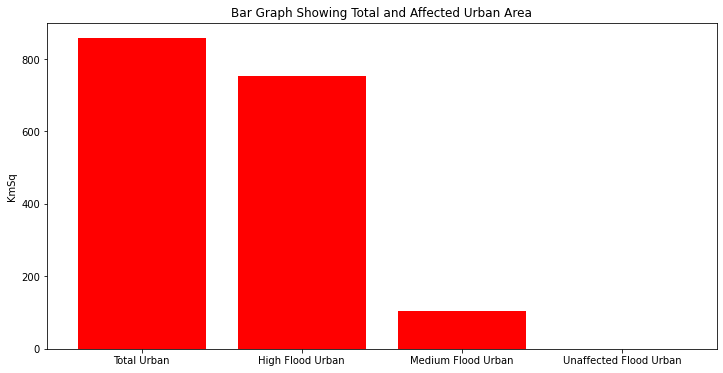

In [178]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(('Total Urban','High Flood Urban', 'Medium Flood Urban', 'Unaffected Flood Urban'),(
    total_urban, h_area_affected_urban, m_area_affected_urban, un_area_affected_urban),facecolor='red')
plt.ylabel('KmSq')
plt.title('Bar Graph Showing Total and Affected Urban Area')

Text(0.5, 1.0, 'Bar Graph Showing Total and Affected Crop Land')

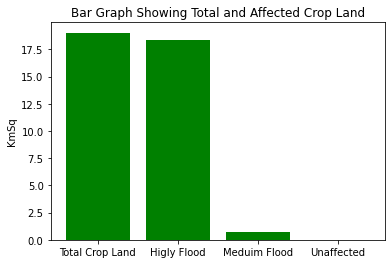

In [179]:
plt.bar(('Total Crop Land','Higly Flood', 'Meduim Flood', 'Unaffected'),(
    total_crop_land, h_area_affected_cropland, m_area_affected_cropland, un_area_affected_cropland),facecolor='Green')
plt.ylabel('KmSq')
plt.title('Bar Graph Showing Total and Affected Crop Land')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [56]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [57]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2022-04-09'